# Class 7b: Tidy format, Visualizations, `xarray` and Modeling

#### Long form ("tidy") data

Tidy data was first defined in the R language (its "tidyverse" subset) as the preferred format for analysis and visualization. If you assume that the data you're about to visualize is always in such a format, you can design plotting libraries that use these assumptions to cut the number of lines of code you have to write in order to see the final art. Tidy data migrated to the Pythonic data science ecosystem, and nowadays it's the preferred data format in the pandas ecosystem as well. The way to construct a "tidy" table is to follow three simple rules:
1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

In the paper [defining tidy data](http://vita.had.co.nz/papers/tidy-data.pdf), the following example is given - Assume we have the following data table:

| name | treatment a | treatment b |
|------|--------------|-------|
| John Smith | - | 20.1 |
| Jane Doe | 15.1 | 13.2 |
| Mary Johnson | 22.8 | 27.5 |

Is this the "tidy" form? What are the variables and observations here? Well, we could've written this table in a different ('transposed') format:

|treatment type| John Smith | Jane Doe | Mary Johnson |
| -------------| -----------| -------- | ------------ |
| treat. a | - | 15.1 | 22.8 |
| treat. b | 20.1 | 13.2 | 27.5 |

Is this "long form"?

In both cases, the answer is no. We have to move each observation into its own row, and in the above two tables two (or more) observations were placed in the same row. For example, Both observations concerning Mary Johnson (the measured value of treatment a and b) were located in the same row, which violates rule #2 of the "tidy" data rules. This is how the tidy version of the above tables look like:

| name | treatment | measurement |
| ---- | --------- | ----------- |
| John Doe | a | - |
| Jane Doe | a | 15.1 |
| Mary Johnson | a | 22.8 |
| John Doe | b | 20.1 |
| Jane Doe | b | 13.2 |
| Mary Johnson | b | 27.5 |

Now each measurement has a single row, and the treatment column became an "index" of some sort. The only shortcoming of this approach is the fact that we now have more cells in the table. We had 9 in the previous two versions, but this one has 18. This is quite a jump, but if we're smart about our data types (categorical data types) then the jump in memory usage wouldn't become too hard.

As I wrote in the previous class, pandas has methods to transform data into its long form. You'll usually need to use `df.stack()` or `df.melt()` to make it tidy. Let's try to make our own data tidy:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("pew_raw.csv")
df

,religion,10000,20000,30000,40000,50000,75000
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Dont know/refused,15,14,15,11,10,35
5,Evangelical Prot,575,869,1064,982,881,1486
6,Hindu,1,9,7,9,11,34
7,Historically Black Prot,228,244,236,238,197,223
8,Jehovahs Witness,20,27,24,24,21,30
9,Jewish,19,19,25,25,30,95


This is a table from the Pew Research Center on the relations between income (in USD) and religion. This dataset is not in a tidy format since the column headers contain information about specific observations (measurements). For example, the 27 agnostic individuals who donated less than \$10k represent a measurement, and the 34 that donated \$10k-20k represent another one, and so on. 

To make it tidy we'll use `melt()`:

In [2]:
tidy_df = (
    pd.melt(df, id_vars=["religion"], var_name="income", value_name="freq")
    .sort_values(by="religion")
    .reset_index(drop=True)
    .astype({"income": "category", "religion": "category"})
)

In [3]:
tidy_df

,religion,income,freq
0,Agnostic,10000,27
1,Agnostic,40000,81
2,Agnostic,50000,76
3,Agnostic,75000,137
4,Agnostic,20000,34
5,Agnostic,30000,60
6,Atheist,50000,35
7,Atheist,30000,37
8,Atheist,20000,27
9,Atheist,40000,52


The first argument to melt is the column name that will be used as the "identifier variable", i.e. will be repeated as necessary to be used as an "index" of some sorts. `var_name` is the new name of the column we made from the values in the old columns, and `value_name` is the name of the column that contains the actual values in the cells from before.

After the melting I sorted the dataframe to make it look prettier (all agnostics in row, etc.) and threw away the old and irrelevant index. Finally I converted the "religion" and "income" columns to a categorical data type, which saves memory and better conveys their true meaning.

## Data Visualization

As mentioned previously the visualization landscape in Python is rich, and is becoming richer by the day. Below, we'll explore some of the options we have.

\* *We'll assume that 2D data is accessed from a dataframe.*

### `matplotlib`

The built-in `df.plot()` method is a simple wrapper around `pyplot` from `matplotlib`, and as we've seen before it works quite well for many types of plots, as long as we wish to keep them all overlayed in some sort. Let's look at examples taken straight from the [visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) manual of pandas:

In [4]:
ts = pd.Series(np.random.randn(1000),
               index=pd.date_range('1/1/2000', periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4),
                  index=ts.index,
                  columns=list('ABCD'))
df = df.cumsum()
df

,A,B,C,D
2000-01-01,1.761123,0.832820,-0.158928,0.793713
2000-01-02,2.043602,0.167185,0.650972,1.810457
2000-01-03,2.643254,0.899856,-0.515626,1.954973
2000-01-04,2.926399,0.217768,1.237854,3.419221
2000-01-05,1.923963,-0.346431,0.862027,2.554569
...,...,...,...,...
2002-09-22,-5.550984,28.924566,49.748085,-18.394013
2002-09-23,-6.445131,27.715798,49.500737,-18.116765
2002-09-24,-6.488587,28.417718,50.163327,-18.158684
2002-09-25,-5.493370,28.830150,48.604050,-18.669184


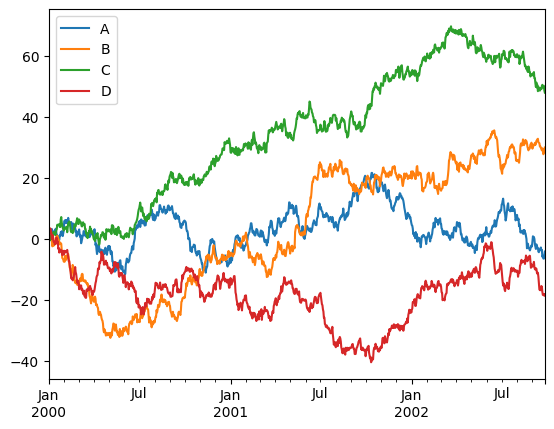

In [5]:
_ = df.plot()

Nice to see we got a few things for "free", like sane x-axis labels and the legend.

We can tell pandas which column corresponds to x, and which to y:

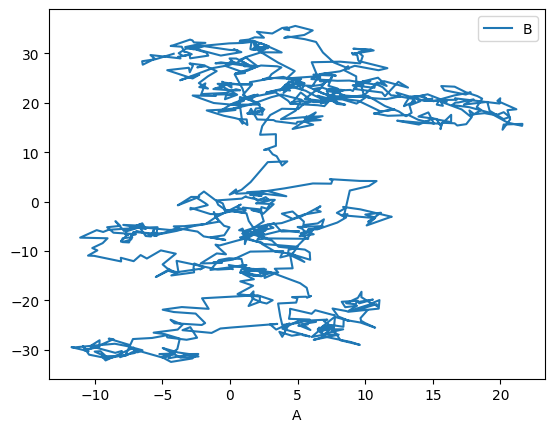

In [6]:
_ = df.plot(x='A', y='B')

There are, of course, many possible types of plots that can be directly called from the pandas interface:

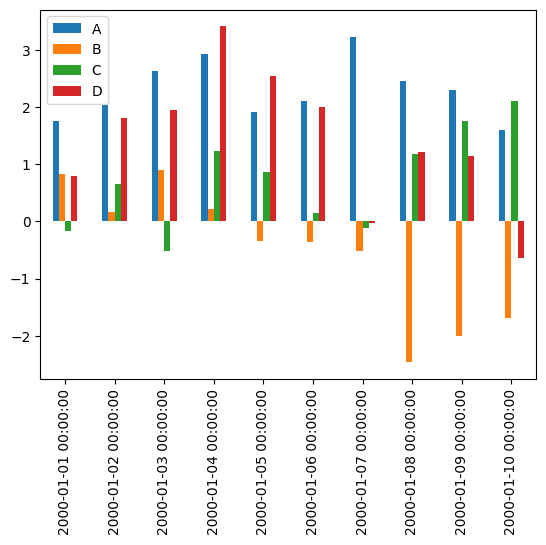

In [7]:
_ = df.iloc[:10, :].plot.bar()

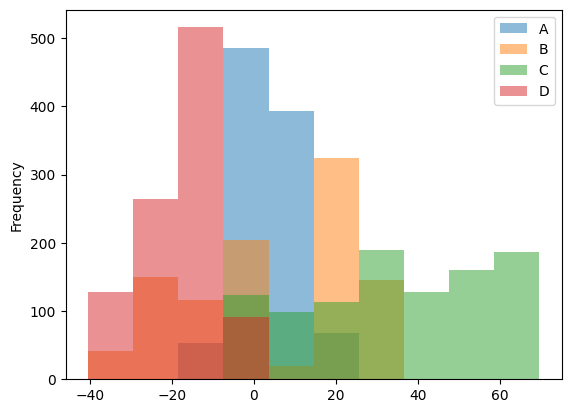

In [8]:
_ = df.plot.hist(alpha=0.5)

Histogramming each column separately can be done by calling the `hist()` method directly:

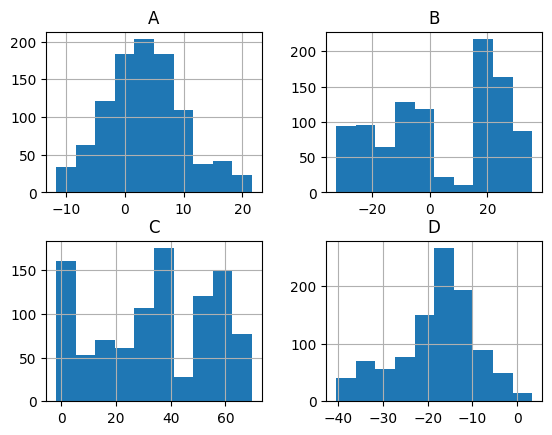

In [9]:
_ = df.hist()

Lastly, a personal favorite:

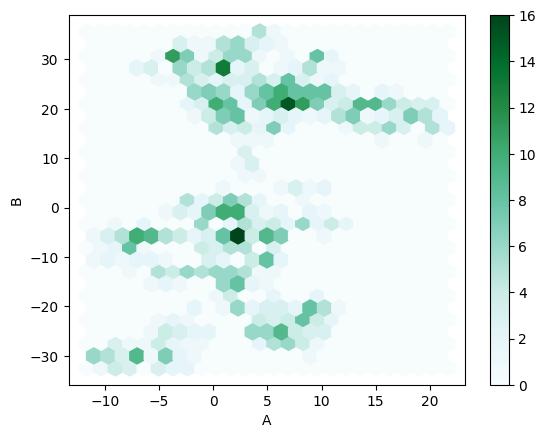

In [10]:
_ = df.plot.hexbin(x='A', y='B', gridsize=25)

### Altair

Matplotlib (and pandas' interface to it) is the gold standard in the Python ecosystem - but there are other ecosystems as well. For example, [`vega-lite`](https://github.com/vega/vega-lite) is a famous plotting library for the web and Javascript, and it uses a different grammar to define its plots. If you're familiar with it you'll be delighted to hear that Python's [`altair`](https://altair-viz.github.io/) provides bindings to it, and even if you've never heard of it it's always nice to see that there are many other different ways to tell a computer how to draw stuff on the screen. Let's look at a couple of examples:

In [11]:
import altair as alt

chart = alt.Chart(df)
chart.mark_point().encode(x='A', y='B')

alt.Chart(...)

In Altair you first create a chart object (a simple `Chart` above), and then you ask it to `mark_point()`, or `mark_line()`, to add that type of visualization to the chart. Then we specify the axis and other types of parameters (like color) and map (or `encode`) them to their corresponding column.

Let's see how Altair works with other datatypes:

In [12]:
datetime_df = pd.DataFrame({'value': np.random.randn(100).cumsum()},
                           index=pd.date_range('2020', freq='D', periods=100))

datetime_df.head()

,value
2020-01-01,0.369911
2020-01-02,0.008972
2020-01-03,-1.119314
2020-01-04,-2.117211
2020-01-05,-2.600371


In [13]:
chart = alt.Chart(datetime_df.reset_index())
chart.mark_line().encode(x='index:T', y='value:Q')

alt.Chart(...)

Above we plot the datetime data by telling Altair that the column named "index" is of type `T`, i.e. Time, while the column "value" is of type `Q` for quantitative.

One of the great things about these charts is that they can easily be made to be interactive:

In [14]:
from vega_datasets import data  # ready-made DFs for easy visualization examples

In [15]:
cars = data.cars
cars()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA
...,...,...,...,...,...,...,...,...,...
401,ford mustang gl,27.0,4,140.0,86.0,2790,15.6,1982-01-01,USA
402,vw pickup,44.0,4,97.0,52.0,2130,24.6,1982-01-01,Europe
403,dodge rampage,32.0,4,135.0,84.0,2295,11.6,1982-01-01,USA
404,ford ranger,28.0,4,120.0,79.0,2625,18.6,1982-01-01,USA


In [16]:
cars_url = data.cars.url
cars_url  # The data is online and in json format which is standard practice for altair-based workflows

'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/cars.json'

In [17]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color='Origin:N',  # N for nominal, i.e. discrete and unordered (just like colors)
)

alt.Chart(...)

In [18]:
brush = alt.selection_interval()  # selection of type 'interval'

In [19]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color='Origin:N',  # N for nominal, i.e.discrete and unordered (just like colors)
).add_selection(brush)

alt.Chart(...)

The selection looks good but doesn't do anything. Let's add functionality:

In [20]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(
    brush
)

alt.Chart(...)

Altair has a ton more visualization types, some of which are more easily generated than others, and some are easier to generate using Altair rather than Matplotlib.

### Bokeh, Holoviews and pandas-bokeh

Bokeh is another visualization effort in the Python ecosystem, but this time it revolves around web-based plots. Bokeh can be used directly, but it also serves as a backend plotting device for more advanced plotting libraries, like Holoviews and pandas-bokeh. It's also designed in mind with huge datasets that don't fit in memory, which is something that other tools might have trouble visualizing.

In [21]:
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure as bkfig
output_notebook()

Loading BokehJS ...

In [22]:
bokeh_figure = bkfig(width=400, height=400)
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]
bokeh_figure.scatter(x,
                    y,
                    size=15,
                    line_color="navy",
                    fill_color="orange",
                    fill_alpha=0.5)

show(bokeh_figure)

We see how bokeh immediately outputs an interactive graph, i.e. an HTML document that will open in your browser (a couple of cells above we kindly asked bokeh to output its plots to the notebook instead). Bokeh can be used for many other types of plots, like:

In [23]:
datetime_df = datetime_df.reset_index()
datetime_df

,index,value
0,2020-01-01,0.369911
1,2020-01-02,0.008972
2,2020-01-03,-1.119314
3,2020-01-04,-2.117211
4,2020-01-05,-2.600371
...,...,...
95,2020-04-05,-9.468766
96,2020-04-06,-10.722551
97,2020-04-07,-10.236193
98,2020-04-08,-10.018318


In [24]:
bokeh_figure_2 = bkfig(x_axis_type="datetime",
                       title="Value over Time",
                       height=350,
                       width=800)

bokeh_figure_2.xgrid.grid_line_color = None
bokeh_figure_2.ygrid.grid_line_alpha = 0.5
bokeh_figure_2.xaxis.axis_label = 'Time'
bokeh_figure_2.yaxis.axis_label = 'Value'

bokeh_figure_2.line(datetime_df.index, datetime_df.value)
show(bokeh_figure_2)

Let's look at [energy consumption, split by source](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html) (from the Pandas-Bokeh manual):

In [25]:
url = "https://raw.githubusercontent.com/PatrikHlobil/Pandas-Bokeh/master/docs/Testdata/energy/energy.csv"
df_energy = pd.read_csv(url, parse_dates=["Year"])
df_energy.head()

,Year,Oil,Gas,Coal,Nuclear Energy,Hydroelectricity,Other Renewable
0,1970-01-01,2291.5,826.7,1467.3,17.7,265.8,5.8
1,1971-01-01,2427.7,884.8,1459.2,24.9,276.4,6.3
2,1972-01-01,2613.9,933.7,1475.7,34.1,288.9,6.8
3,1973-01-01,2818.1,978.0,1519.6,45.9,292.5,7.3
4,1974-01-01,2777.3,1001.9,1520.9,59.6,321.1,7.7


Another Bokeh-based library is Holoviews. Its uniqueness stems from the way it handles DataFrames with multiple columns, and the way you add plots to each other. It's very suitable for Jupyter notebook based plots:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
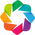

In [26]:
import holoviews as hv
hv.extension("bokeh")

In [27]:
df_energy.head()

,Year,Oil,Gas,Coal,Nuclear Energy,Hydroelectricity,Other Renewable
0,1970-01-01,2291.5,826.7,1467.3,17.7,265.8,5.8
1,1971-01-01,2427.7,884.8,1459.2,24.9,276.4,6.3
2,1972-01-01,2613.9,933.7,1475.7,34.1,288.9,6.8
3,1973-01-01,2818.1,978.0,1519.6,45.9,292.5,7.3
4,1974-01-01,2777.3,1001.9,1520.9,59.6,321.1,7.7


In [28]:
scatter = hv.Scatter(df_energy, 'Oil', 'Gas')
scatter

:Scatter   [Oil]   (Gas)

In [29]:
scatter + hv.Curve(df_energy, 'Oil', 'Hydroelectricity')

:Layout
   .Scatter.I :Scatter   [Oil]   (Gas)
   .Curve.I   :Curve   [Oil]   (Hydroelectricity)

In [30]:
def get_year_coal(df, year) -> int:
    return df.loc[df["Year"] == year, "Coal"]

items = {year: hv.Bars(get_year_coal(df_energy, year)) for year in df_energy["Year"]}
                       
hv.HoloMap(items, kdims=['Year'])

:HoloMap   [Year]
   :Bars   [index]   (Coal)

Holoviews really needs an entire class (or two) to go over its concepts, but once you get them you can create complicated visualizations which include a strong interactive component in a few lines of code.

### Seaborn

A library which has really become a shining example of quick, efficient and clear plotting in the post-pandas era is `seaborn`. It combines many of the features of the previous libraries into a very concise API. Unlike a few of the previous libraries, however, it doesn't use bokeh as its backend, but matplotlib, which means that the interactivity of the resulting plots isn't as good. Be that as it may, it's still a widely used library, and for good reasons.

In order to use seaborn to its full extent (and really all of the above libraries) we have to take a short detour and understand how to transform our data into a **long-form format.**

Once we have this long form data, we can put seaborn to the test.

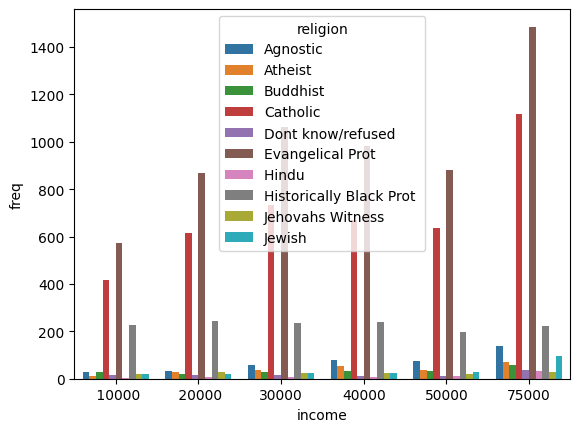

In [31]:
import seaborn as sns

income_barplot = sns.barplot(data=tidy_df, x='income', y='freq', hue='religion')

To fix the legend location:

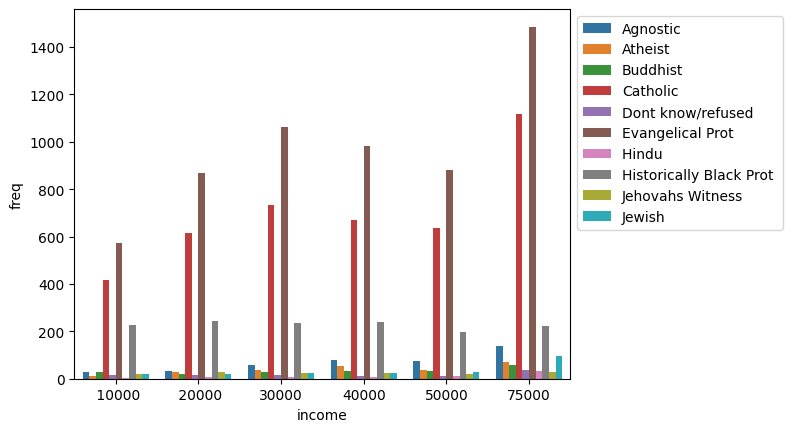

In [32]:
income_barplot = sns.barplot(data=tidy_df, x='income', y='freq', hue='religion')
_ = income_barplot.legend(bbox_to_anchor=(1, 1))

Each seaborn [visualization functions](https://seaborn.pydata.org/api.html) has a "data" keyword to which you pass your dataframe, and then a few other with which you specify the relations of the columns to one another. Look how simple it was to receive this beautiful bar chart.

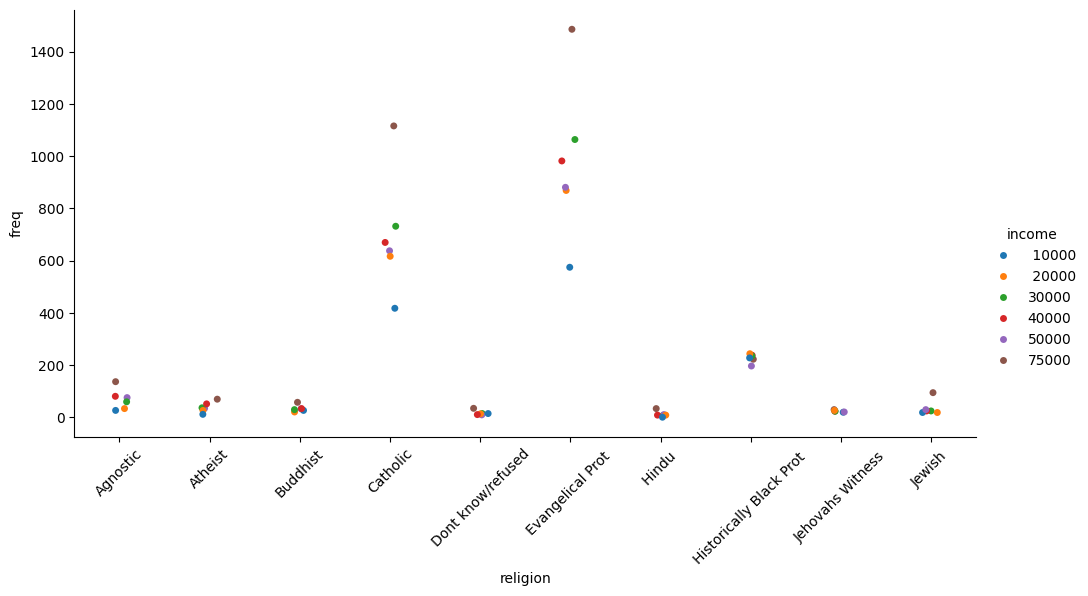

In [33]:
income_catplot = sns.catplot(data=tidy_df, x="religion", y="freq", hue="income", aspect=2)
_ = plt.xticks(rotation=45)

Seaborn also takes care of faceting the data for us:

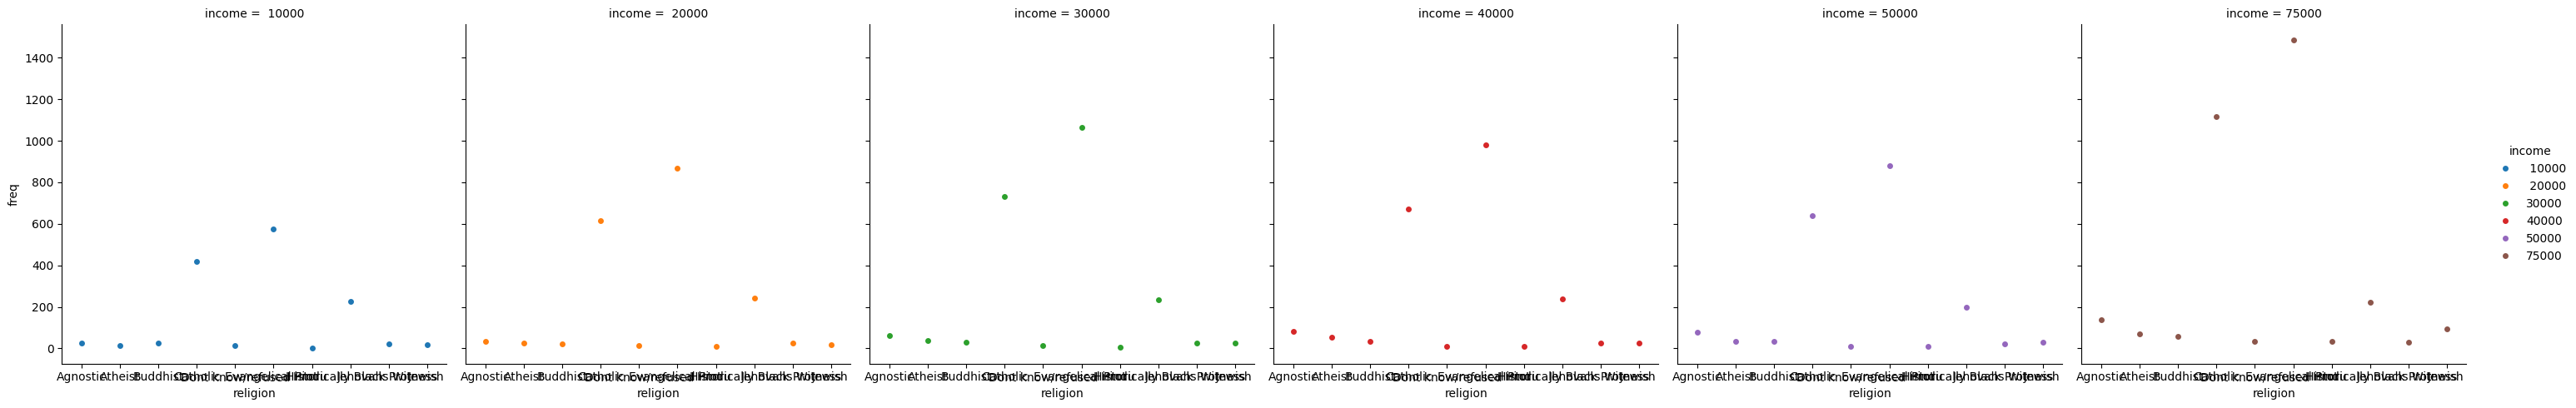

In [34]:
_ = sns.catplot(data=tidy_df, x="religion", y="freq", hue="income", col="income")

Figure is a bit small? We can use matplotlib to change it:

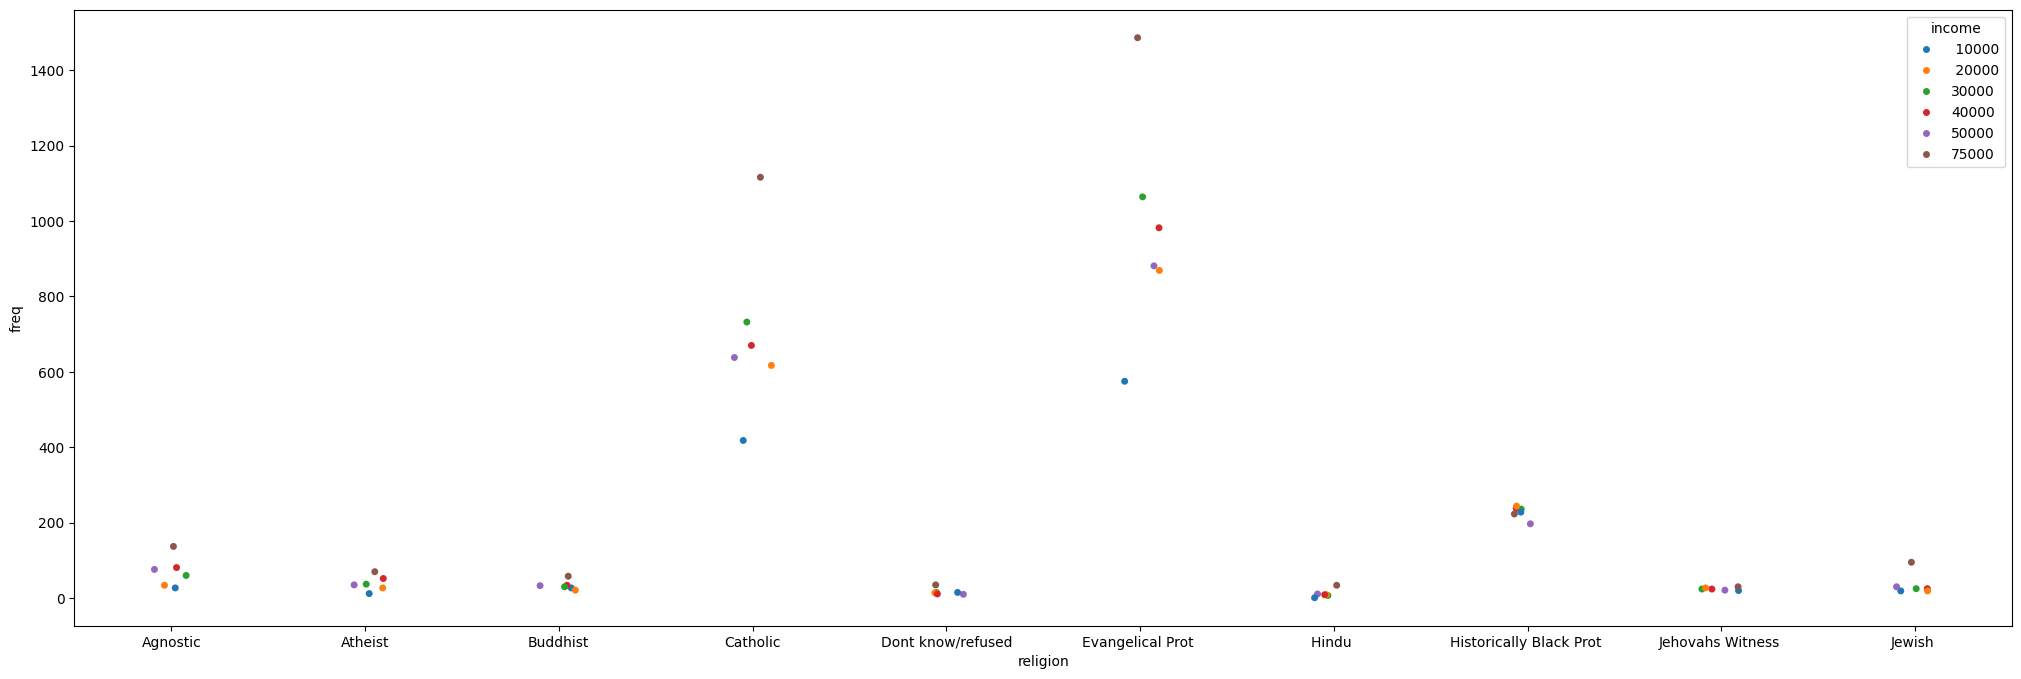

In [35]:
_, ax = plt.subplots(figsize=(25, 8))
_ = sns.stripplot(data=tidy_df, x="religion", y="freq", hue="income", ax=ax)

Simpler data can also be visualized, no need for categorical variables:

In [36]:
simple_df = pd.DataFrame(np.random.random((1000, 4)), columns=list('abcd'))
simple_df

,a,b,c,d
0,0.461195,0.592999,0.761030,0.429983
1,0.405213,0.309611,0.190770,0.763129
2,0.783879,0.238234,0.107468,0.827677
3,0.172146,0.637937,0.879961,0.433097
4,0.722669,0.296148,0.825063,0.758699
...,...,...,...,...
995,0.197433,0.138332,0.938017,0.039734
996,0.285137,0.871456,0.371458,0.900780
997,0.032411,0.189876,0.430765,0.389765
998,0.426249,0.688778,0.778960,0.546464


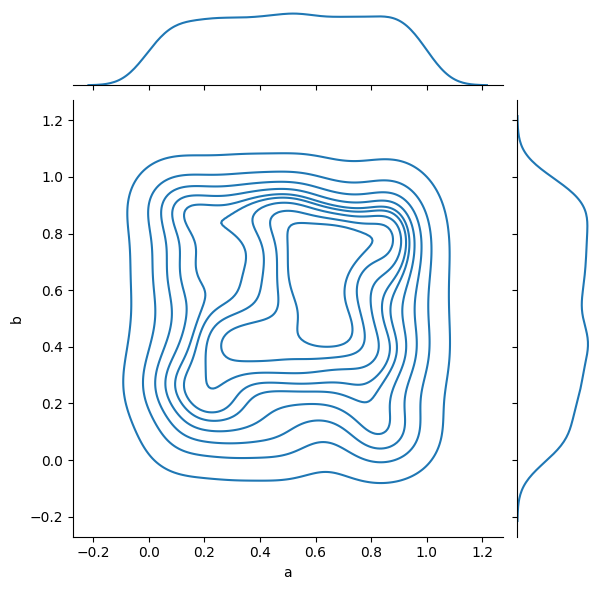

In [37]:
_ = sns.jointplot(data=simple_df, x='a', y='b', kind='kde')

And complex relations can also be visualized:

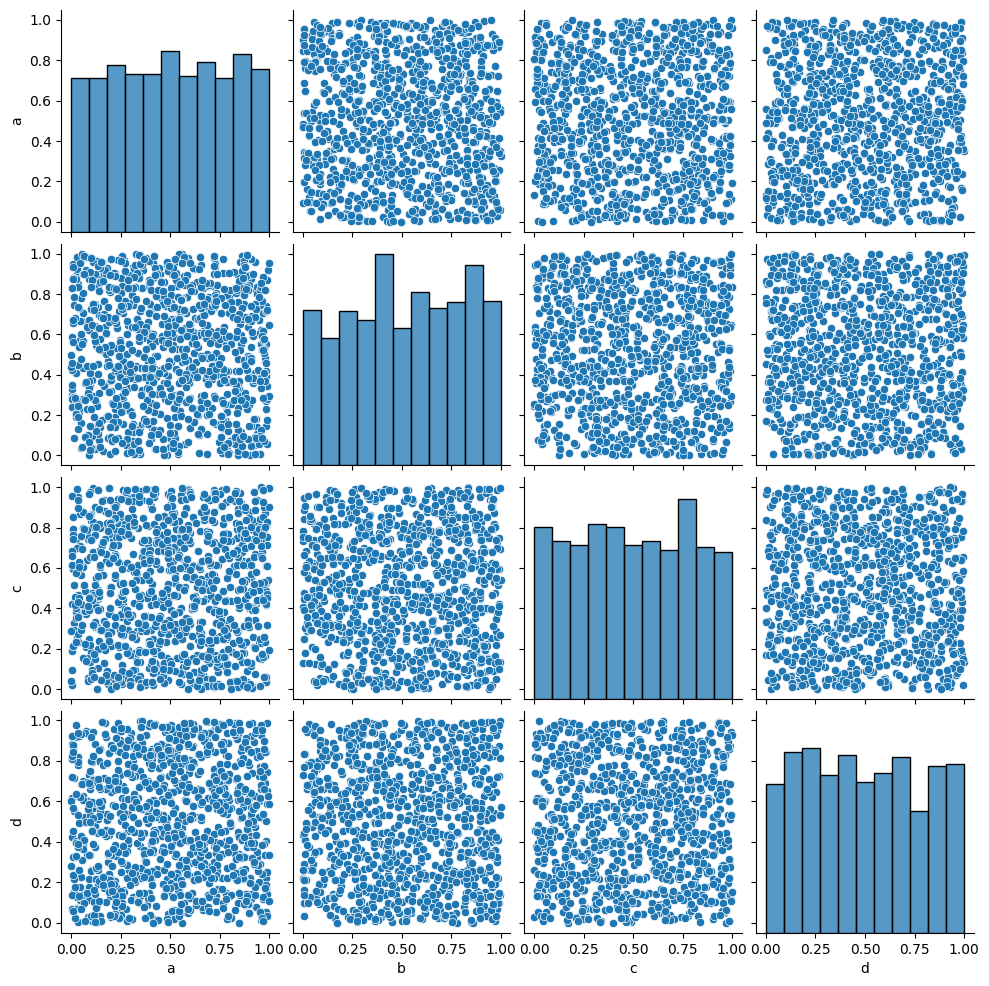

In [38]:
_ = sns.pairplot(data=simple_df)

Seaborn should probably be your go-to choice when all you need is a 2D graph.

## Higher Dimensionality: `xarray`

Pandas is amazing, but has its limits. A `DataFrame` can be a multi-dimensional container when using a `MultiIndex`, but it's limited to a subset of uses in which another layer of indexing makes sense.

In many occasions, however, our data is truly high-dimensional. A simple case could be electro-physiological recordings, or calcium traces. In these cases we have several indices (some can be categorical), like "Sex", "AnimalID", "Date", "TypeOfExperiment" and perhaps a few more. But the data itself is a vector of numbers representing voltage or fluorescence. Having this data in a dataframe seems a bit "off", what are the columns on this dataframe? Is each column a voltage measurement? Or if each column is a measurement, how do you deal with the indices? We can use nested columns (`MultiIndex` the columns), but it's not a very modular approach.

This is a classic example where pandas' dataframes "fail", and indeed pandas used to have a higher-dimensionality container named `Panel`. However, in late 2016 pandas developers deprecated it, publicly announcing that they intend to drop support for `Panel`s sometime in the future, and whoever needs a higher-dimensionality container should use `xarray`.

`xarray` is a labeled n-dimensional array. Just like a DataFrame is a labeled 2D array, i.e. with names to its axes rather than numbers, in `xarray` each dimension has a name (`time`, `temp`, `voltage`) and its indices ("coordinates") can also have labels (like a timestamp, for example). In addition, each `xarray` object also has metadata attached to it, in which we can write details that do not fit a columnar structure (experimenter name, hardware and software used for acquisition, etc.).

### DataArray

In [39]:
import numpy as np
import xarray as xr

da = xr.DataArray(np.random.random((10, 2)))
da

<xarray.DataArray (dim_0: 10, dim_1: 2)> Size: 160B
array([[0.37653001, 0.41386593],
       [0.32875623, 0.62685528],
       [0.25434934, 0.08698457],
       [0.12720003, 0.64844421],
       [0.56319427, 0.78248245],
       [0.41888055, 0.09462761],
       [0.93989211, 0.60502699],
       [0.8604643 , 0.89761611],
       [0.54444438, 0.70813225],
       [0.73778238, 0.26763537]])
Dimensions without coordinates: dim_0, dim_1

The basic building block of `xarray` is a DataArray, an n-dimensional counter part of a pandas' Series. It has two dimensions, just like the numpy array that its based upon. We didn't specify names for these dimensions, so currently they're called `dim_0` and `dim_1`. We also didn't specify coordinates (indices), so the printout doesn't report of any coordinates for the data.

In [40]:
da.values  # just like pandas

array([[0.37653001, 0.41386593],
       [0.32875623, 0.62685528],
       [0.25434934, 0.08698457],
       [0.12720003, 0.64844421],
       [0.56319427, 0.78248245],
       [0.41888055, 0.09462761],
       [0.93989211, 0.60502699],
       [0.8604643 , 0.89761611],
       [0.54444438, 0.70813225],
       [0.73778238, 0.26763537]])

In [41]:
da.coords

Coordinates:
    *empty*

In [42]:
da.dims

('dim_0', 'dim_1')

In [43]:
da.attrs

{}

We'll add coordinates and dimension names and see how indexing works:

In [44]:
dims = ('time', 'repetition')
coords = {'time': np.linspace(0, 1, num=10),
          'repetition': np.arange(2)}
da2 = xr.DataArray(np.random.random((10, 2)), dims=dims, coords=coords)
da2

<xarray.DataArray (time: 10, repetition: 2)> Size: 160B
array([[0.06609615, 0.54948441],
       [0.2508715 , 0.19158609],
       [0.85915342, 0.05351732],
       [0.6367359 , 0.26282929],
       [0.44780809, 0.99864228],
       [0.43588958, 0.33027974],
       [0.1311911 , 0.86305329],
       [0.10452604, 0.26589094],
       [0.13015455, 0.16956528],
       [0.2457762 , 0.4614647 ]])
Coordinates:
  * time        (time) float64 80B 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 16B 0 1

In [45]:
da2.loc[0.1:0.3, 1]  # rows 1-2 in the second column

<xarray.DataArray (time: 2)> Size: 16B
array([0.19158609, 0.05351732])
Coordinates:
  * time        (time) float64 16B 0.1111 0.2222
    repetition  int64 8B 1

In [46]:
da2.isel(time=slice(3, 7))  # dimension name and integer label (sel = select)

<xarray.DataArray (time: 4, repetition: 2)> Size: 64B
array([[0.6367359 , 0.26282929],
       [0.44780809, 0.99864228],
       [0.43588958, 0.33027974],
       [0.1311911 , 0.86305329]])
Coordinates:
  * time        (time) float64 32B 0.3333 0.4444 0.5556 0.6667
  * repetition  (repetition) int64 16B 0 1

In [47]:
da2.sel(time=slice(0.1, 0.3), repetition=[1])  # dimension name and coordinate label

<xarray.DataArray (time: 2, repetition: 1)> Size: 16B
array([[0.19158609],
       [0.05351732]])
Coordinates:
  * time        (time) float64 16B 0.1111 0.2222
  * repetition  (repetition) int64 8B 1

Other operations on `DataArray` instances, such as computations, grouping and such, are done very similarly to dataframes and numpy arrays.

### Dataset

A `Dataset` is to a `DataArray` what a `DataFrame` is to a `Series`. In other words, it's a collection of `DataArray` instances that share coordinates.

In [48]:
da2  # a reminder. We notice that this could've been a DataFrame as well

<xarray.DataArray (time: 10, repetition: 2)> Size: 160B
array([[0.06609615, 0.54948441],
       [0.2508715 , 0.19158609],
       [0.85915342, 0.05351732],
       [0.6367359 , 0.26282929],
       [0.44780809, 0.99864228],
       [0.43588958, 0.33027974],
       [0.1311911 , 0.86305329],
       [0.10452604, 0.26589094],
       [0.13015455, 0.16956528],
       [0.2457762 , 0.4614647 ]])
Coordinates:
  * time        (time) float64 80B 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 16B 0 1

In [49]:
ds = xr.Dataset({'ephys': da2,
                 'calcium': ('time', np.random.random(10))},
                attrs={'AnimalD': 701,
                       'ExperimentType': 'double',
                       'Sex': 'Male'})
ds

<xarray.Dataset> Size: 336B
Dimensions:     (time: 10, repetition: 2)
Coordinates:
  * time        (time) float64 80B 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 16B 0 1
Data variables:
    ephys       (time, repetition) float64 160B 0.0661 0.5495 ... 0.2458 0.4615
    calcium     (time) float64 80B 0.01493 0.1709 0.06686 ... 0.623 0.1154
Attributes:
    AnimalD:         701
    ExperimentType:  double
    Sex:             Male

In [50]:
ds['ephys']  # individual DataArrays can be dissimilar in shape

<xarray.DataArray 'ephys' (time: 10, repetition: 2)> Size: 160B
array([[0.06609615, 0.54948441],
       [0.2508715 , 0.19158609],
       [0.85915342, 0.05351732],
       [0.6367359 , 0.26282929],
       [0.44780809, 0.99864228],
       [0.43588958, 0.33027974],
       [0.1311911 , 0.86305329],
       [0.10452604, 0.26589094],
       [0.13015455, 0.16956528],
       [0.2457762 , 0.4614647 ]])
Coordinates:
  * time        (time) float64 80B 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 16B 0 1

### Exercise: Rat Visual Stimulus Experiment Database

You're measuring the potential of neurons in a rat's brain over time in response to flashes of light
using a multi-electrode array surgically inserted into the rat's skull. Each trial is two seconds
long, and one second into the trial a short, 100 ms, bright light is flashed at the animal. After 30 seconds
the experiment is replicated, for a total of 4 repetitions. The relevant parameters are the following:

- Rat ID.
- Experimenter name.
- Rat gender.
- Measured voltage (10 electrode, 10k samples representing two seconds).
- Stimulus index (mark differently the pre-, during- and post-stimulus time).
- Repetition number.

Mock data and model it, you can add more parameters if you feel so.

Experimental timeline:
```
       1s          100ms             0.9s             30s
Start -----> Flash -----> End flash -----> End trial -----> New trial
|                                                                    |
|--------------------------------------------------------------------|
                                   x4
```

#### Methods and functions to implement

1. There should be a class holding this data table, `VisualStimData`, alongside
several methods for the analysis of the data. The class should have a `data`
attribute containing the data table, in a `xarray.DataArray` or a `xarray.Dataset`.

2. Write a function (not a method) that returns an instance of the class with mock data.
    ```python
    def mock_stim_data() -> VisualStimData:
        """ Creates a new VisualStimData instance with mock data """
    ```

    When simulating the recorded voltage, it's completely fine to not model spikes precisely,
    with leaky integration and so forth - randoming numbers and treating them as the recorded
    neural potential is fine. There are quite a few ways to model _real_ neurons,
    if so you wish, [brian](http://brian2.readthedocs.io/en/stable/index.html) being one
    of them. If your own research will benefit from knowing how to use these tools, this
    exercise is a great place to start familiarizing yourself with them.

3. Write a method that receives a repetition number, rat ID, and a list of electrode numbers,
and plots the voltage recorded from these electrodes. The single figure should be
divided into however many plots needed, depending on the length of the list of electrode
numbers.

    ```python
    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with subplots.
        """
    ```

4. To see if the different experimenters influence the measurements, write a method that
calculates the mean, standard deviation and median of the average voltage trace across all
repetitions, for each experimenter, and shows a bar plot of it.

    ```python
    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
    ```

#### Exercise solutions below...

In [51]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class VisualStimData:
    """
    Data and methods for the visual stimulus ePhys experiment.
    The data table itself is held in self.data, an `xarray` object.
    Inputs:
        data: xr.DataArray or xr.Dataset
    Methods:
         ...
    """
    def __init__(self, data: xr.Dataset, ):
        assert isinstance(data, xr.Dataset)
        self.data = data


    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with two subplots, for male and female rats.
        """
        fig, axes = plt.subplots(len(elec_number), 1)
        axes = np.array([axes]) if isinstance(axes, plt.Axes) else axes
        time = self.data['time']
        for ax, elec in zip(axes, elec_number):
            to_plot = self.data.sel(rep=rep_number, rat_id=rat_id, elec=elec)['volt'].values
            ax.plot(time, to_plot)
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Voltage [V]')
            ax.set_title(f'Electrode {elec}')

        fig.tight_layout()

    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
        names = np.unique(self.data.coords['exp_name'].values)
        means = []
        stds = []
        medians = []
        for experimenter in names:
            data = self.data.sel(exp_name=experimenter)['volt'].values
            means.append(np.abs(data.mean()))
            stds.append(np.abs(data.std()))
            medians.append(np.abs(np.median(data)))

        # Plotting
        fig, ax = plt.subplots()
        x_locs = np.arange(len(names))
        width = 0.3
        rect0 = ax.bar(x_locs, means, width, color='C0')
        rect1 = ax.bar(x_locs + width, stds, width, color='C1')
        rect2 = ax.bar(x_locs - width, medians, width, color='C2')

        ax.set_xticks(x_locs)
        ax.set_xticklabels(names)
        ax.legend((rect0[0], rect1[0], rect2[0]), ('Mean', 'STD', 'Median'))
        ax.set_title('Experimenter Bias (absolute values)')
        ax.set_ylabel('Volts [V]')

In [52]:
def mock_stim_data() -> VisualStimData:
    """ Creates a new VisualStimData instance with mock data """
    num_of_animals = 20
    num_of_reps = 4
    reps = np.arange(num_of_reps, dtype=np.uint8)
    total_num_of_exp = num_of_animals * num_of_reps
    exp_number = np.arange(total_num_of_exp, dtype=np.uint32)
    
    rat_id_ints, rat_id = _generate_rat_data(num_of_animals)
    room_temp, room_humid = _generate_temp_hum_values(total_num_of_exp)
    experimenters = _generate_experimenter_names(num_of_animals, num_of_reps)
    rat_sex = _generate_rat_gender(num_of_animals, num_of_reps)
    stim, electrode_array, time, volt = _generate_voltage_stim(num_of_animals, num_of_reps)

    # Construct the Dataset - this could be done with a pd.MultiIndex as well
    ds = xr.Dataset({'temp': (['num'], room_temp),
                     'humid': (['num'], room_humid),
                     'volt': (['elec', 'time', 'rat_id', 'rep'], volt),
                     'stim': (['time'], stim)},
                    coords={'elec': electrode_array,
                            'time': time,
                            'rat_id': rat_id,
                            'rep': reps,
                            'exp_name': experimenters,
                            'sex': rat_sex,
                            'num': exp_number,
                            })

    ds.attrs['exp_date'] = pd.to_datetime('today')
    ds.attrs['rat_strain'] = 'Sprague Dawley'

    return VisualStimData(ds)
    
def _generate_rat_data(num_of_animals):
    rat_id_ints = np.random.choice(np.arange(100, 900), size=300, replace=False)
    rat_id = np.random.choice(rat_id_ints, size=num_of_animals, replace=False)
    return rat_id_ints, rat_id


def _generate_temp_hum_values(total_num_of_exp):
    room_temp = np.random.random(total_num_of_exp) * 3 + 23  # between 23 and 26 C
    room_humid = np.random.randint(30, 70, size=total_num_of_exp)
    return room_temp, room_humid

def _generate_experimenter_names(num_of_animals, num_of_reps):
    names = ['Dana', 'Motti', 'Sam', 'Daria']
    experimenters = np.random.choice(names, size=num_of_animals, replace=True)
    experimenters = np.tile(experimenters, num_of_reps)
    return experimenters

def _generate_rat_gender(num_of_animals, num_of_reps):
    sex = ['F', 'M']
    rat_sex = np.random.choice(sex, size=num_of_animals, replace=True)
    rat_sex = np.tile(rat_sex, num_of_reps)
    return rat_sex


def _generate_voltage_stim(num_of_animals, num_of_reps):
    pre_stim = 1  # seconds
    stim_time = 0.1  # seconds
    post_stim = 0.9  # seconds
    sampling_rate = 5000  # Hz
    freq = 1 / sampling_rate
    experiment_length = int(pre_stim + stim_time + post_stim)
    electrodes = 10
    samples = sampling_rate * experiment_length

    # Random voltage values from N(0.068, 0.0004)
    volt = 0.02 * np.random.randn(electrodes, samples, num_of_animals,
                                 num_of_reps).astype(np.float32) - 0.068  # in volts, not millivolts
    volt[volt > -0.02] = 0.04  # "spikes"
    time = pd.date_range(start=pd.to_datetime('today'), periods=experiment_length * sampling_rate,
                         freq=f'{freq}S')
    electrode_array = np.arange(electrodes, dtype=np.uint16)

    # Stim index - -1 is pre, 0 is stim, 1 is post
    stim = np.zeros(int(samples), dtype=np.int8)
    stim[:int(pre_stim*sampling_rate)] = -1
    stim[int((pre_stim + stim_time)*sampling_rate):] += 1
    return stim, electrode_array, time, volt

/tmp/ipykernel_235389/2117857072.py:72: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start=pd.to_datetime('today'), periods=experiment_length * sampling_rate,


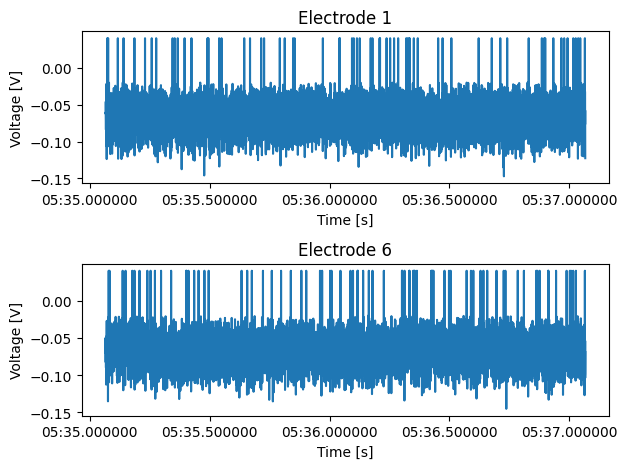

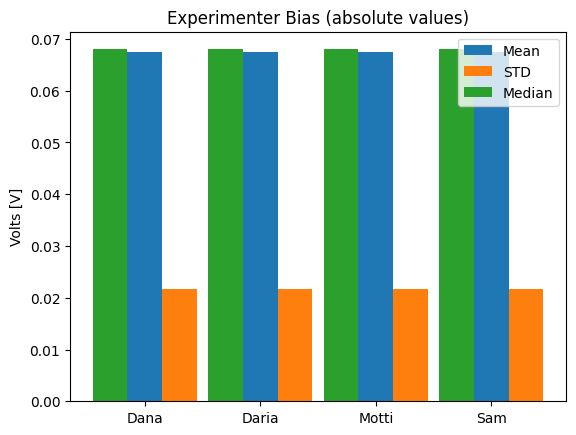

In [53]:
# Run the solution
stim_data = mock_stim_data()
ids = stim_data.data['rat_id']
arr = stim_data.plot_electrode(rep_number=2, rat_id=ids[0], elec_number=(1, 6))
stim_data.experimenter_bias()

In [54]:
stim_data.data

<xarray.Dataset> Size: 32MB
Dimensions:   (num: 80, elec: 10, time: 10000, rat_id: 20, rep: 4,
               exp_name: 80, sex: 80)
Coordinates:
  * elec      (elec) uint16 20B 0 1 2 3 4 5 6 7 8 9
  * time      (time) datetime64[ns] 80kB 2025-05-12T10:05:35.066515 ... 2025-...
  * rat_id    (rat_id) int64 160B 177 441 168 100 286 ... 806 717 846 386 342
  * rep       (rep) uint8 4B 0 1 2 3
  * exp_name  (exp_name) <U5 2kB 'Sam' 'Sam' 'Sam' ... 'Motti' 'Sam' 'Daria'
  * sex       (sex) <U1 320B 'F' 'M' 'M' 'F' 'M' 'M' ... 'F' 'F' 'F' 'M' 'F' 'M'
  * num       (num) uint32 320B 0 1 2 3 4 5 6 7 8 ... 71 72 73 74 75 76 77 78 79
Data variables:
    temp      (num) float64 640B 23.17 23.11 24.81 23.57 ... 24.67 25.46 25.98
    humid     (num) int64 640B 41 54 59 40 34 49 42 52 ... 64 60 38 55 61 65 34
    volt      (elec, time, rat_id, rep) float32 32MB -0.04674 ... -0.06986
    stim      (time) int8 10kB -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    exp_date:    2025-05-12 10:05:35.068532
    rat_strain:  Sprague Dawley